In [1]:
import numpy as np
import pandas as pd
import copy
import time
import matplotlib.pyplot as plt
from datetime import datetime

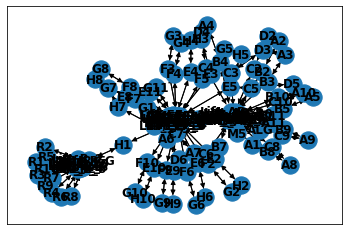

In [2]:
from Distance_Matrix_v2 import graph, ward_list
from Distance_Matrix_v2 import get_shortest_path_length
from Distance_Matrix_v2 import get_shortest_path

In [3]:
import warnings
warnings.filterwarnings("ignore")

#  Define GA

In [4]:
def GA(df,node,n_vehicle,start,n_population,p_mutate,n_iteration):
    
    # -----------------------------define helper functions--------------------------------------#
    def travel_time(solution):# not consider the time back to the start from the last ward
        time = 0
        if len(solution) != 0:
            for i in range(len(solution)):
                if i == 0:
                    time += get_shortest_path_length(graph,start,solution[i])
    #             elif i == (len(solution)):
    #                 time += get_shortest_path_length(graph,solution[i-1],start)
                else:
                    time += get_shortest_path_length(graph,solution[i-1],solution[i])
            return time
        else:return 0

    def split_solution(solution):# give the route of each vehicle in one possible solution
        split = []       
        if start not in solution:
            split.append(solution)
        else:
            solution = pd.Series(solution)
            index = solution[solution.values == start].index

            for i in range(len(index)+1):
                if i == 0:
                    v = solution[:index[i]].reset_index(drop = True)
                elif i == len(index):
                    v = solution[(index[len(index)-1]+1):(len_solution)].reset_index(drop = True)
                else:
                    v = solution[(index[i-1]+1):index[i]].reset_index(drop = True)
                split.append(v.tolist())

        return split    

    def travel_time_v(solution):# calculate the travel time of each vehicle
        t_time_v = []
        for i in split_solution(solution):
            t_time_v.append(travel_time(i))

        return t_time_v

    def service_time_v(solution):# calculate the service time of each vehicle
        sevrice_t = []
        for i in split_solution(solution):  
            temp = 0
            for j in i:
                temp += int(data[data.Request_Ward == j].iloc[:,1])*2
            sevrice_t.append(temp)    

        return sevrice_t

    def request_v(solution):# calculate the number of requests finished by each vehicle
        fullfilled_request = []
        for i in split_solution(solution):
            temp = 0
            for j in i:
                temp += int(data[data.Request_Ward == j].iloc[:,1])
            fullfilled_request.append(temp)

        return fullfilled_request

    def initial_sol(wards_list):# draw intitial solution using nearest neighbor
        matrix_weight = pd.DataFrame()
        a = wards_list.tolist()
        for ward_1 in a:
            list_weight = []
            for ward_2 in a:
                list_weight.append(get_shortest_path_length(graph, ward_1, ward_2))
            matrix_weight[ward_1] = list_weight
        matrix_weight.index = a   

        sol_initial = []

        for i in range(n_vehicle): 
            if len(a) == 0:
                sol_initial.append(start)
            else:
                route = []
                ward = np.random.choice(a)
                route.append(ward)
                sol_initial.append(ward)
                a.remove(ward)

                while ((travel_time_v(route)[0] + service_time_v(route)[0] < 120) and (len(a) > 1)):
                    nearest_ward = [matrix_weight.loc[route[-1], a].idxmin() if (len(a) > 1) else a[0]][0]
                    route.append(nearest_ward)
                    sol_initial.append(nearest_ward)
                    a.remove(nearest_ward)
                    matrix_weight = matrix_weight.drop(ward, axis=0)
                    matrix_weight = matrix_weight.drop(ward, axis=1)
                    ward = nearest_ward 

                sol_initial.append(start)

        if len(a) != 0:
            for j in a:
                sol_initial.append(j) 

        return sol_initial
    
    # define objective function
    r, alpha, beta, gamma, k = 100, 1, 3, 1, 20
    max_overtime = 135
    max_underload = 0

    def reward(solution, r):
        reward = sum(request_v(solution)[:-1]) * r
        return reward

    def travel_time_cost(solution, alpha):
        travel_time_cost = np.sum(travel_time_v(solution)[:-1])* alpha
        return travel_time_cost

    def uneven_caseload_cost(solution, beta):
        ave_caseload = sum(request_v(solution)[:-1])/n_vehicle
        uneven_caseload_cost = 0
        for i in request_v(solution)[:-1]:
            uneven_caseload_cost += abs(i - ave_caseload) * beta
        return uneven_caseload_cost

    def uneven_time_cost(solution, gamma):
        tot_time = []
        for i,j in zip(service_time_v(solution)[:-1],travel_time_v(solution)[:-1]):
            tot_time.append(i+j)        
        ave_time_cost = sum(tot_time[:-1])/n_vehicle

        uneven_time_cost = 0
        for k in tot_time:
            uneven_time_cost += abs(k - ave_time_cost) * gamma
        return uneven_time_cost


    def overtime_underload_cost(solution, k, max_overtime, max_underload):
        overtime_underload_cost = 0
        for i,j in zip(service_time_v(solution)[:-1],travel_time_v(solution)[:-1]):
            if ((i+j) <= max_overtime) and ((i+j) >= max_underload):overtime_underload_cost += 0
            elif (i+j) > max_overtime:overtime_underload_cost += ((i+j) - max_overtime)** 2 * k 
            else:overtime_underload_cost +=  (max_underload - (i+j))** 2 * k 
        return overtime_underload_cost

    # Set up the objective function
    def objective_function(solution, r, alpha, beta, k, max_overtime, max_underload):
        objective_function = reward(solution, r) - travel_time_cost(solution, alpha) - uneven_caseload_cost(solution, beta) \
        - overtime_underload_cost(solution, k, max_overtime, max_underload)
        return objective_function

    def crossover(population):# create a child solution using two parent solution
        p_index = list(np.random.randint(0,len(population),2))
        parent0 = list(population.iloc[p_index[0]])[:len_solution]
        parent1 = list(population.iloc[p_index[1]])[:len_solution]
        c_index = list(np.random.randint(0,len(parent0),2))
        temp = parent0[np.min(c_index):np.max(c_index)]
        child = temp + parent1
        for i in temp:
            child.remove(i)

        c_obj = objective_function(child, r, alpha, beta, k, max_overtime, max_underload)
        child.append(c_obj)

        return child

    def mutate(population):# create a new solution based on an old solution
        index_mutate = np.random.randint(0,len(population))
        parent = list(population.iloc[index_mutate])[:len_solution]
        index = list(np.random.randint(0,len_solution,2))
        temp = parent[index[0]]
        parent[index[0]] = parent[index[1]]
        parent[index[1]] = temp

        p_obj = objective_function(parent, r, alpha, beta, k, max_overtime, max_underload)
        parent.append(p_obj)

        return parent
    #----------------------------------------------------------------------------------------------------------#

    request_left = pd.DataFrame()
    output_all = []

    for t in range(len(node)):# how many rounds in one day

        if t == 0:
            request_new = df[df.Exam_Datetime < node[t]].groupby('Request_Ward').sum().reset_index()
            data = pd.concat([request_left,request_new]).reset_index(drop = True)

        else:
            request_new = df[((df.Exam_Datetime >= node[t-1]) & (df.Exam_Datetime < node[t]))].groupby('Request_Ward').sum().reset_index()
            data = pd.concat([request_left,request_new]).groupby('Request_Ward').sum().reset_index()

        ward_lists = data[data.iloc[:,1] != 0]['Request_Ward']        

        n_request = len(ward_lists)
        len_solution = n_vehicle + n_request

        start_time = time.time()

        obj = []
        population = []
        np.random.seed(0)
        for i in range(n_population):
            request = initial_sol(ward_lists)
    #         request = list(np.random.choice(ward_list, n_request, replace = False))
    #         for i in range(n_vehicle):
    #             request.append(start)
    #         # while valid(request):
    #             np.random.shuffle(request)

            obj.append(objective_function(request, r, alpha, beta, k, max_overtime, max_underload))
            population.append(request)

        begin = pd.DataFrame(population)
        begin['obj_value'] = obj
        gen1 = begin.sort_values('obj_value',ascending = False).reset_index(drop = True)

        best_sol = []
        best_obj_value = []
        best_mean_travel_time = []
        best_mean_service_time = []
        best_sum_request_finished = []

        gen_temp = gen1
        for i in range(n_iteration):
            gen_temp = gen_temp.iloc[0:int(n_population/2)]
            for i in range(len(gen_temp)):
                p = np.random.rand()
                if p > 1-np.random.rand():
                    child = mutate(gen_temp)
                else:
                    child = crossover(gen_temp)
                child = pd.DataFrame([child])
                child.columns = list(gen1.columns)
                gen_temp = pd.concat([gen_temp,child])

            gen_temp = gen_temp.sort_values('obj_value',ascending = False).reset_index(drop = True)
            best_sol.append(gen_temp.iloc[0])
            best_obj_value.append(gen_temp.iloc[0]['obj_value'])
            best_mean_travel_time.append(np.mean(travel_time_v(gen_temp.iloc[0].tolist())[:-1]))
            best_mean_service_time.append(np.mean(service_time_v(gen_temp.iloc[0].tolist())[:-1]))
            best_sum_request_finished.append(np.sum(request_v(gen_temp.iloc[0].tolist())[:-1]))

        end_time = time.time()
        comp_time = end_time - start_time

        best_solution = best_sol[best_obj_value.index(np.max(best_obj_value))].tolist()

        route_v = split_solution(best_solution)
        n_frequest = request_v(best_solution)
        trl_time = travel_time_v(best_solution)
        ser_time = service_time_v(best_solution)
        tot_time = []

        request_left = data[data['Request_Ward'].isin(route_v[-1])]

        for i,j in zip(service_time_v(best_solution),travel_time_v(best_solution)):
            tot_time.append(i+j)

        output_dic = {
            'route': route_v,
            'total_time': tot_time,
            'travel_time': trl_time,
            'service_time': ser_time,
            'n_requests_finished':n_frequest,
            'obj_value':best_solution[-1],
            'comp_time':comp_time
        }

        plt.figure(dpi = 300, figsize = (24,8))

        plt.subplot(1,4,1)
        plt.plot(np.arange(1,len(best_obj_value)+1),best_obj_value)
        plt.title('obj_value',fontsize = 20)

        plt.subplot(1,4,2)
        plt.plot(np.arange(1,len(best_mean_travel_time)+1),best_mean_travel_time)
        plt.title('mean_travel_time',fontsize = 20)      

        plt.subplot(1,4,3)
        plt.plot(np.arange(1,len(best_mean_service_time)+1),best_mean_service_time)
        plt.title('mean_service_time',fontsize = 20)

        plt.subplot(1,4,4)
        plt.plot(np.arange(1,len(best_sum_request_finished)+1),best_sum_request_finished)
        plt.title('sum_request_finished',fontsize = 20)

        plt.show()
        
        print(output_dic)
        output_all.append(output_dic)

    return output_all

# Load Data & Set up Input

In [5]:
df = pd.read_csv('sub20230114_full.csv',parse_dates = ['Exam_Datetime'], infer_datetime_format = True, encoding = 'utf-8')

In [6]:
n_vehicle = 5
start = 'H1'
n_population = 100
p_mutate = 0.2
n_iteration = 30

time_list = ['2023-01-14 08:00:00','2023-01-14 10:30:00','2023-01-14 13:00:00',
             '2023-01-14 15:30:00','2023-01-14 18:00:00','2023-01-14 23:59:59']
node = []
for t in time_list:
    node.append(datetime.strptime(t,'%Y-%m-%d %H:%M:%S'))

# Run GA & Show the Results

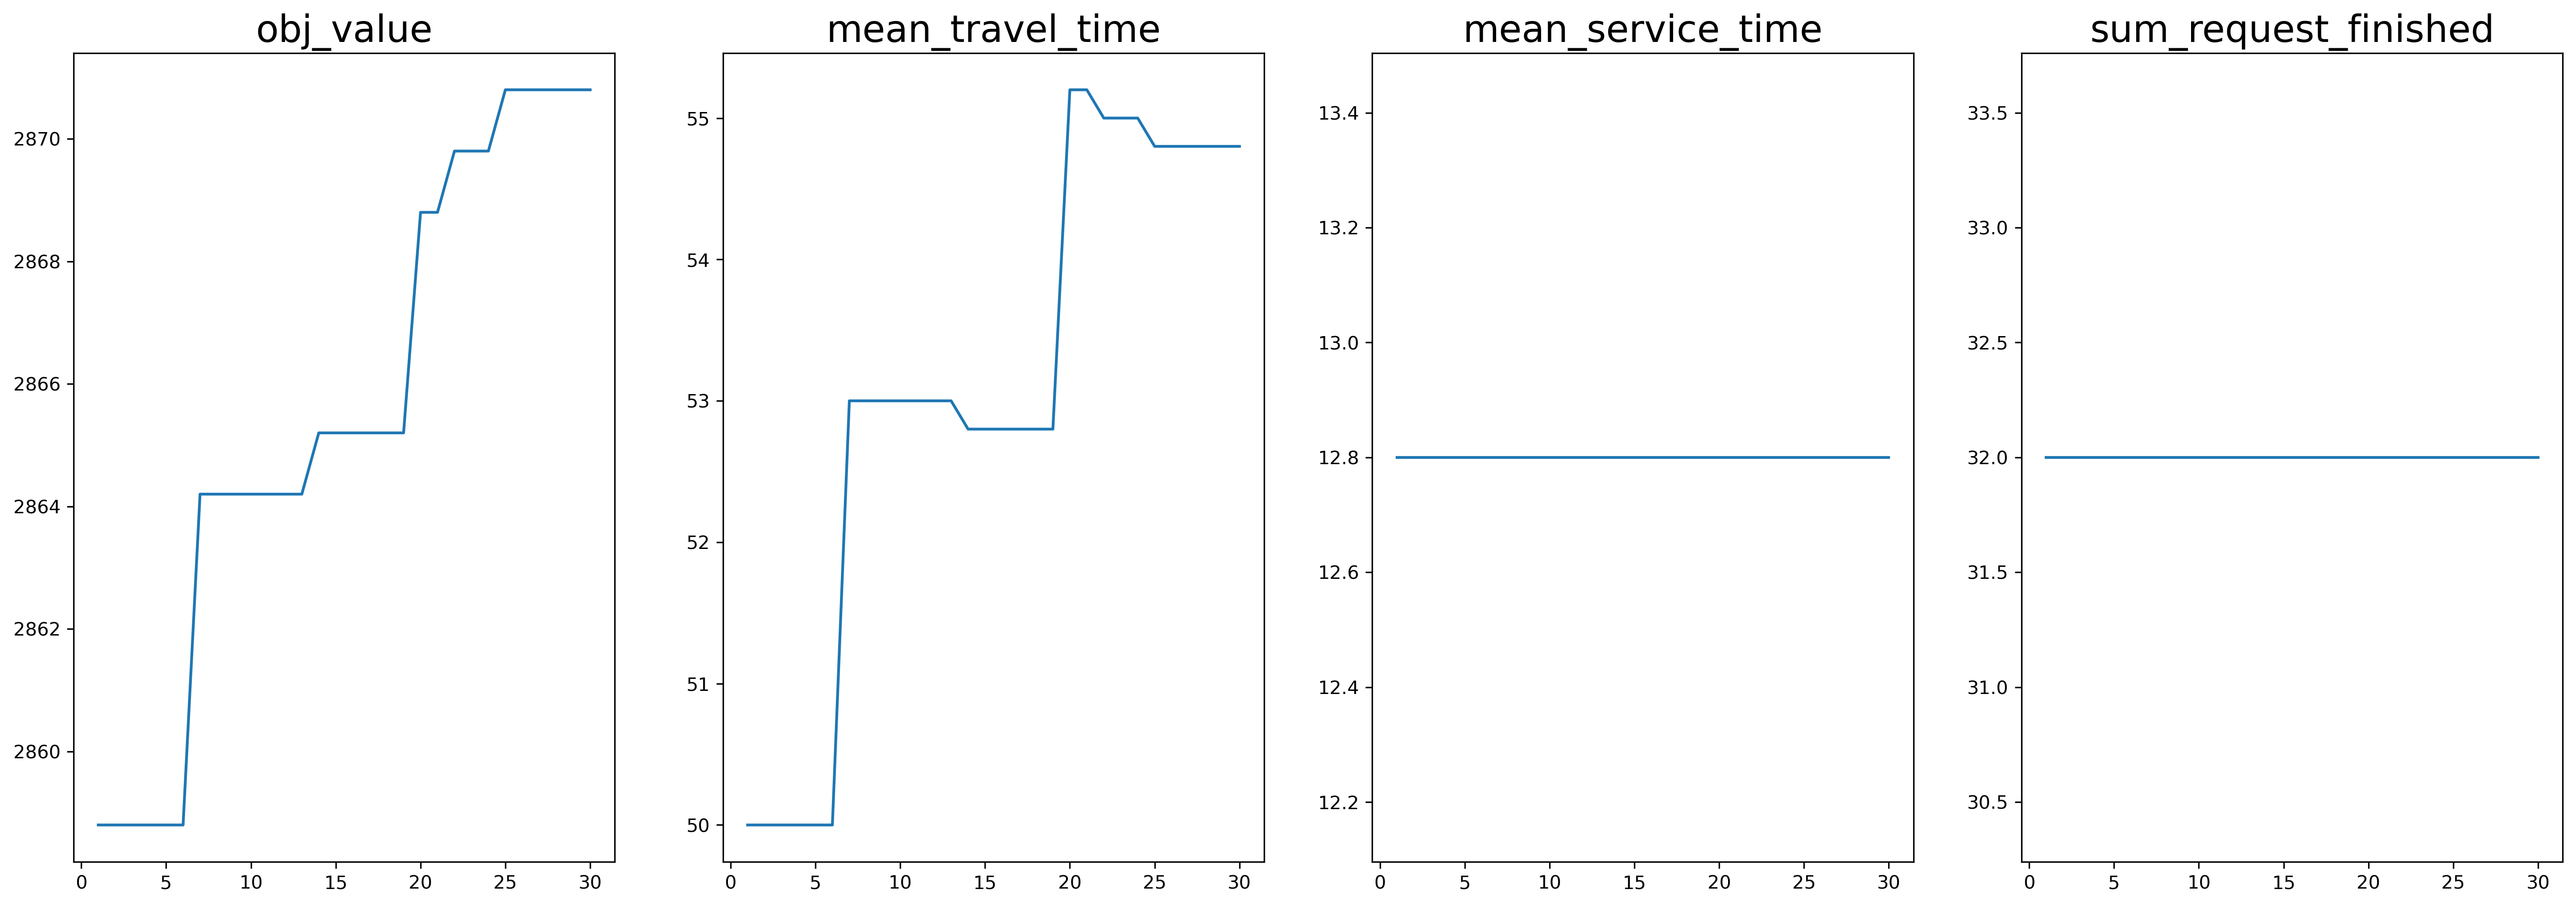

{'route': [['B5', 'B10', 'C9', 'C7', 'E7', 'G7'], ['G10', 'H10', 'E8', 'E6', 'G6'], ['C6', 'A6'], ['A3', 'C3', 'B2'], [], []], 'total_time': [123.0, 92.0, 48.0, 75.0, 0, 0], 'travel_time': [103.0, 68.0, 36.0, 67.0, 0, 0], 'service_time': [20, 24, 12, 8, 0, 0], 'n_requests_finished': [10, 12, 6, 4, 0, 0], 'obj_value': 2870.8, 'comp_time': 44.36354470252991}


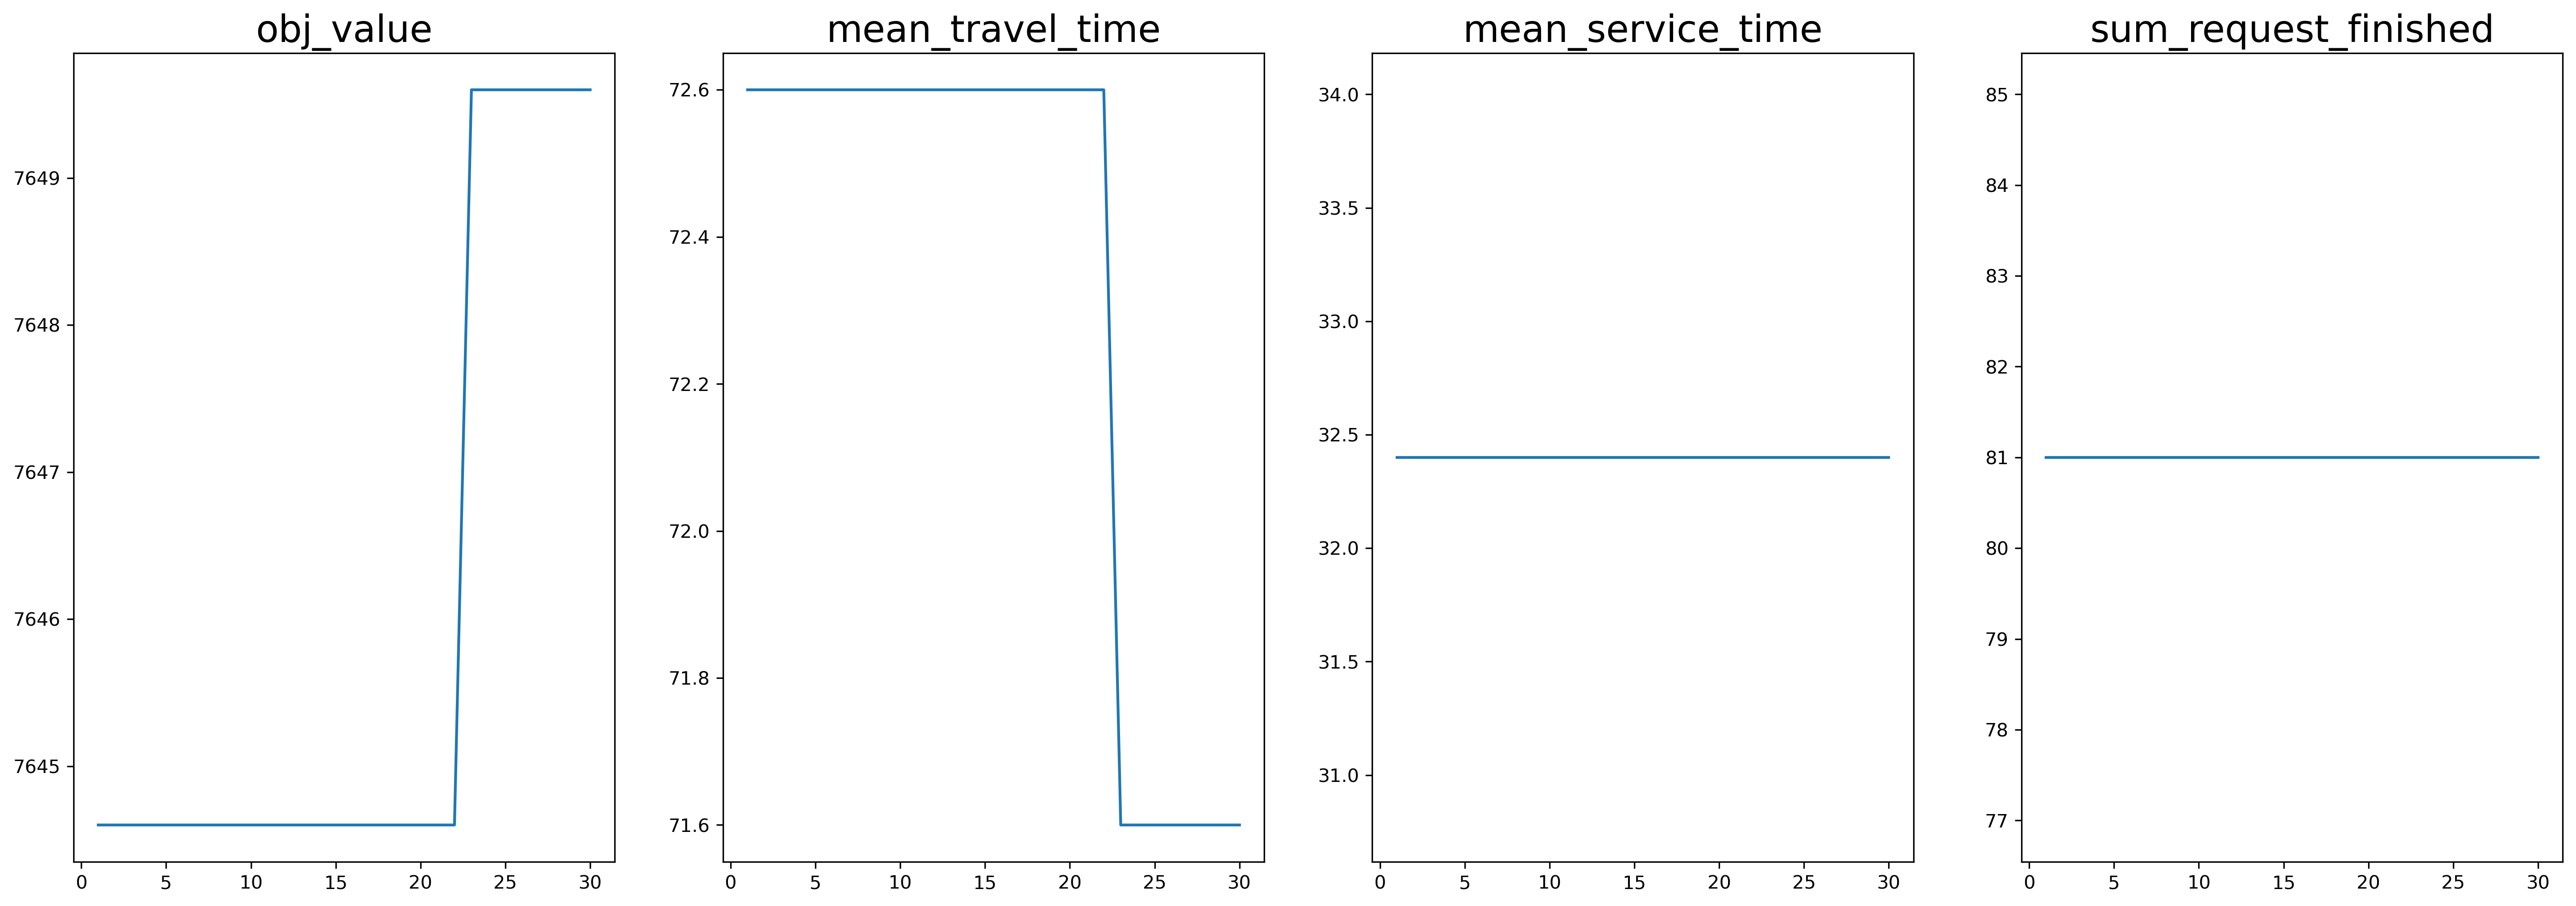

{'route': [['A8', 'C8', 'A10', 'B10', 'C11', 'C7', 'A7', 'E7'], ['A4', 'C4', 'E4', 'H4', 'G4', 'E11'], ['H10', 'G10', 'E8', 'H8', 'G7', 'H7'], ['C6', 'D6', 'A6', 'B6', 'E6', 'H6', 'G6', 'E2', 'G2'], ['H3'], []], 'total_time': [127.0, 130.0, 123.0, 113.0, 27.0, 0], 'travel_time': [93.0, 88.0, 71.0, 83.0, 23.0, 0], 'service_time': [34, 42, 52, 30, 4, 0], 'n_requests_finished': [17, 21, 26, 15, 2, 0], 'obj_value': 7649.6, 'comp_time': 81.61424493789673}


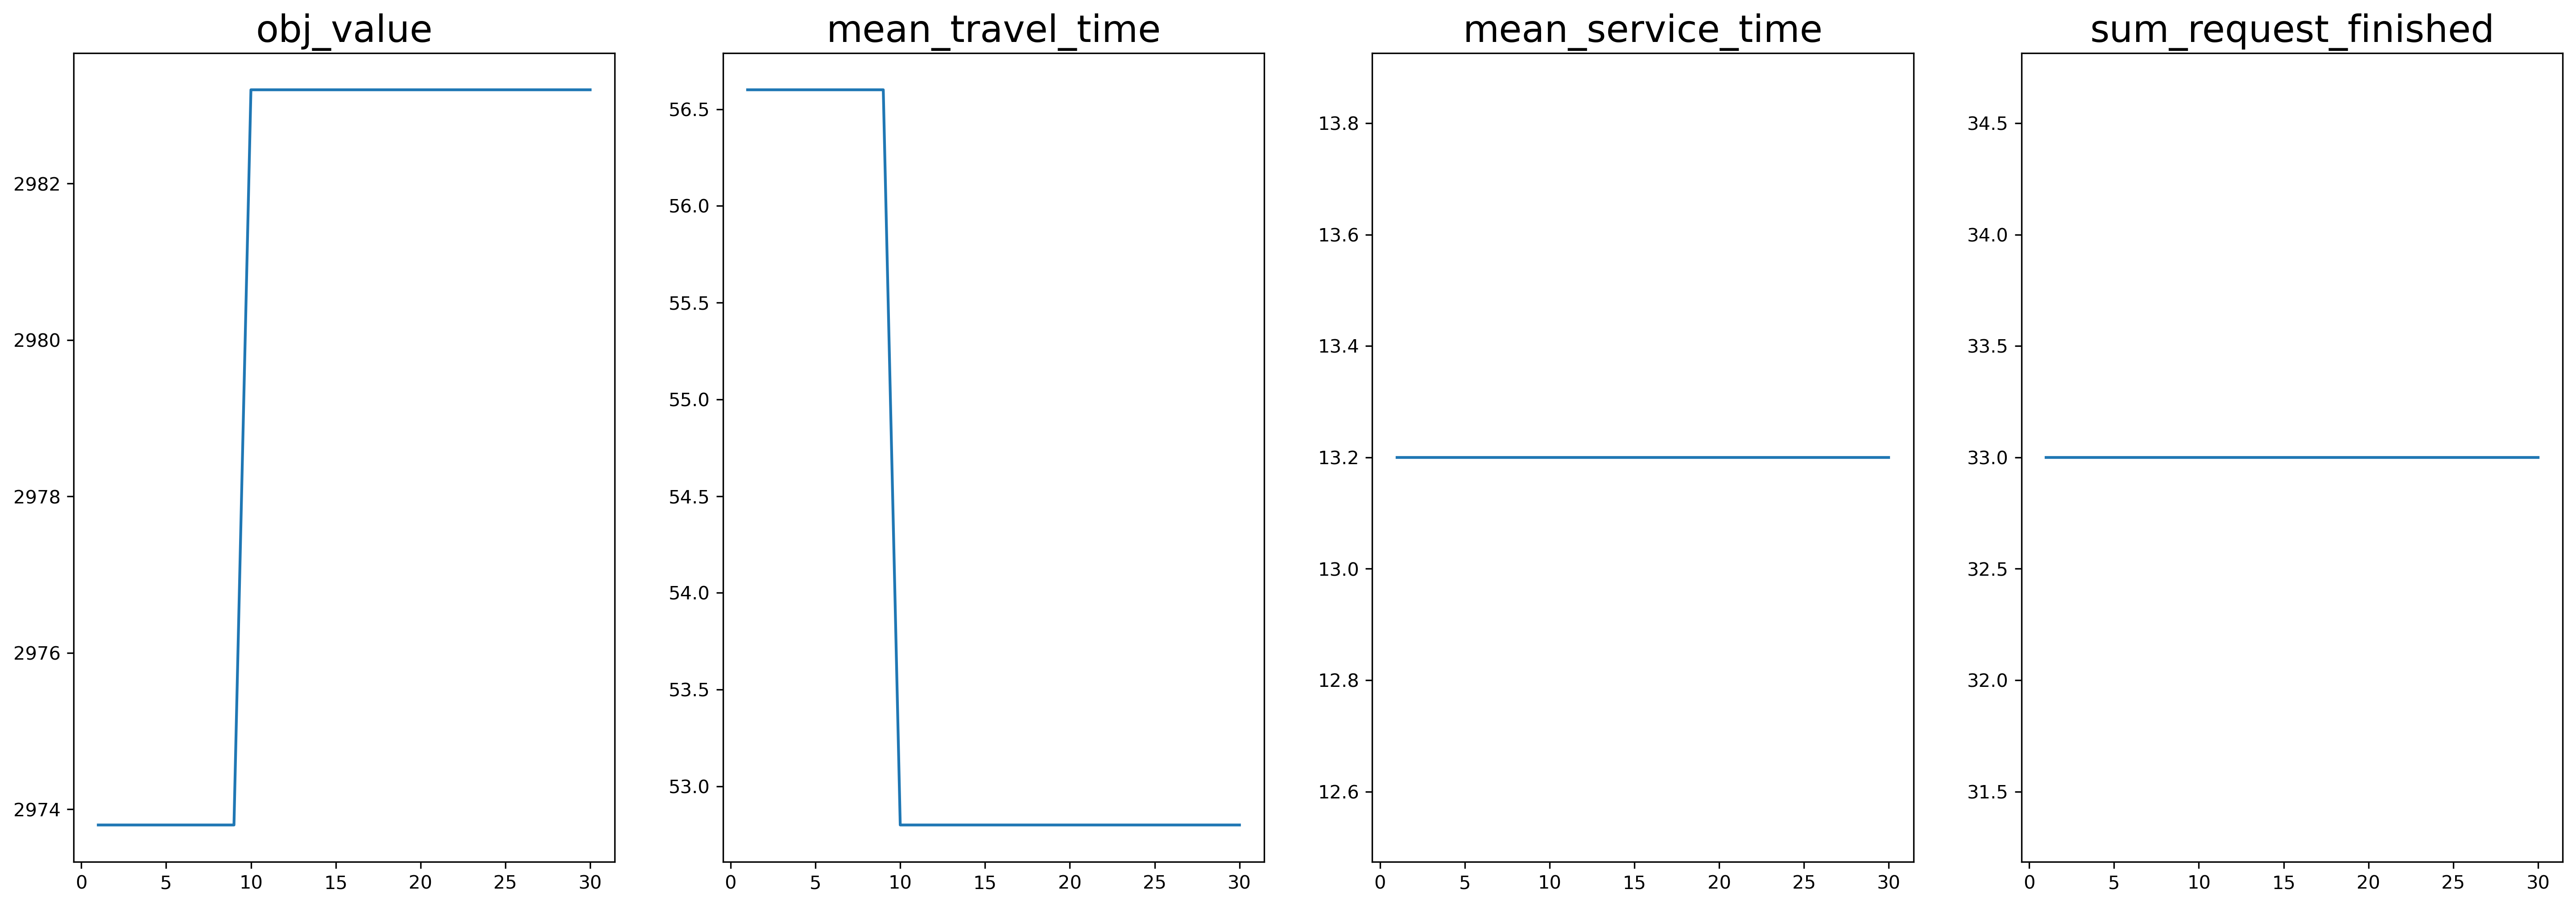

{'route': [['G7', 'E7', 'C7', 'A7', 'A11', 'B10', 'B9', 'C9'], ['E9', 'F10'], ['E3', 'H3', 'A3'], ['B2'], ['E4', 'A5'], []], 'total_time': [122.0, 50.0, 51.0, 32.0, 75.0, 0], 'travel_time': [94.0, 44.0, 39.0, 28.0, 59.0, 0], 'service_time': [28, 6, 12, 4, 16, 0], 'n_requests_finished': [14, 3, 6, 2, 8, 0], 'obj_value': 2983.2, 'comp_time': 44.74885940551758}


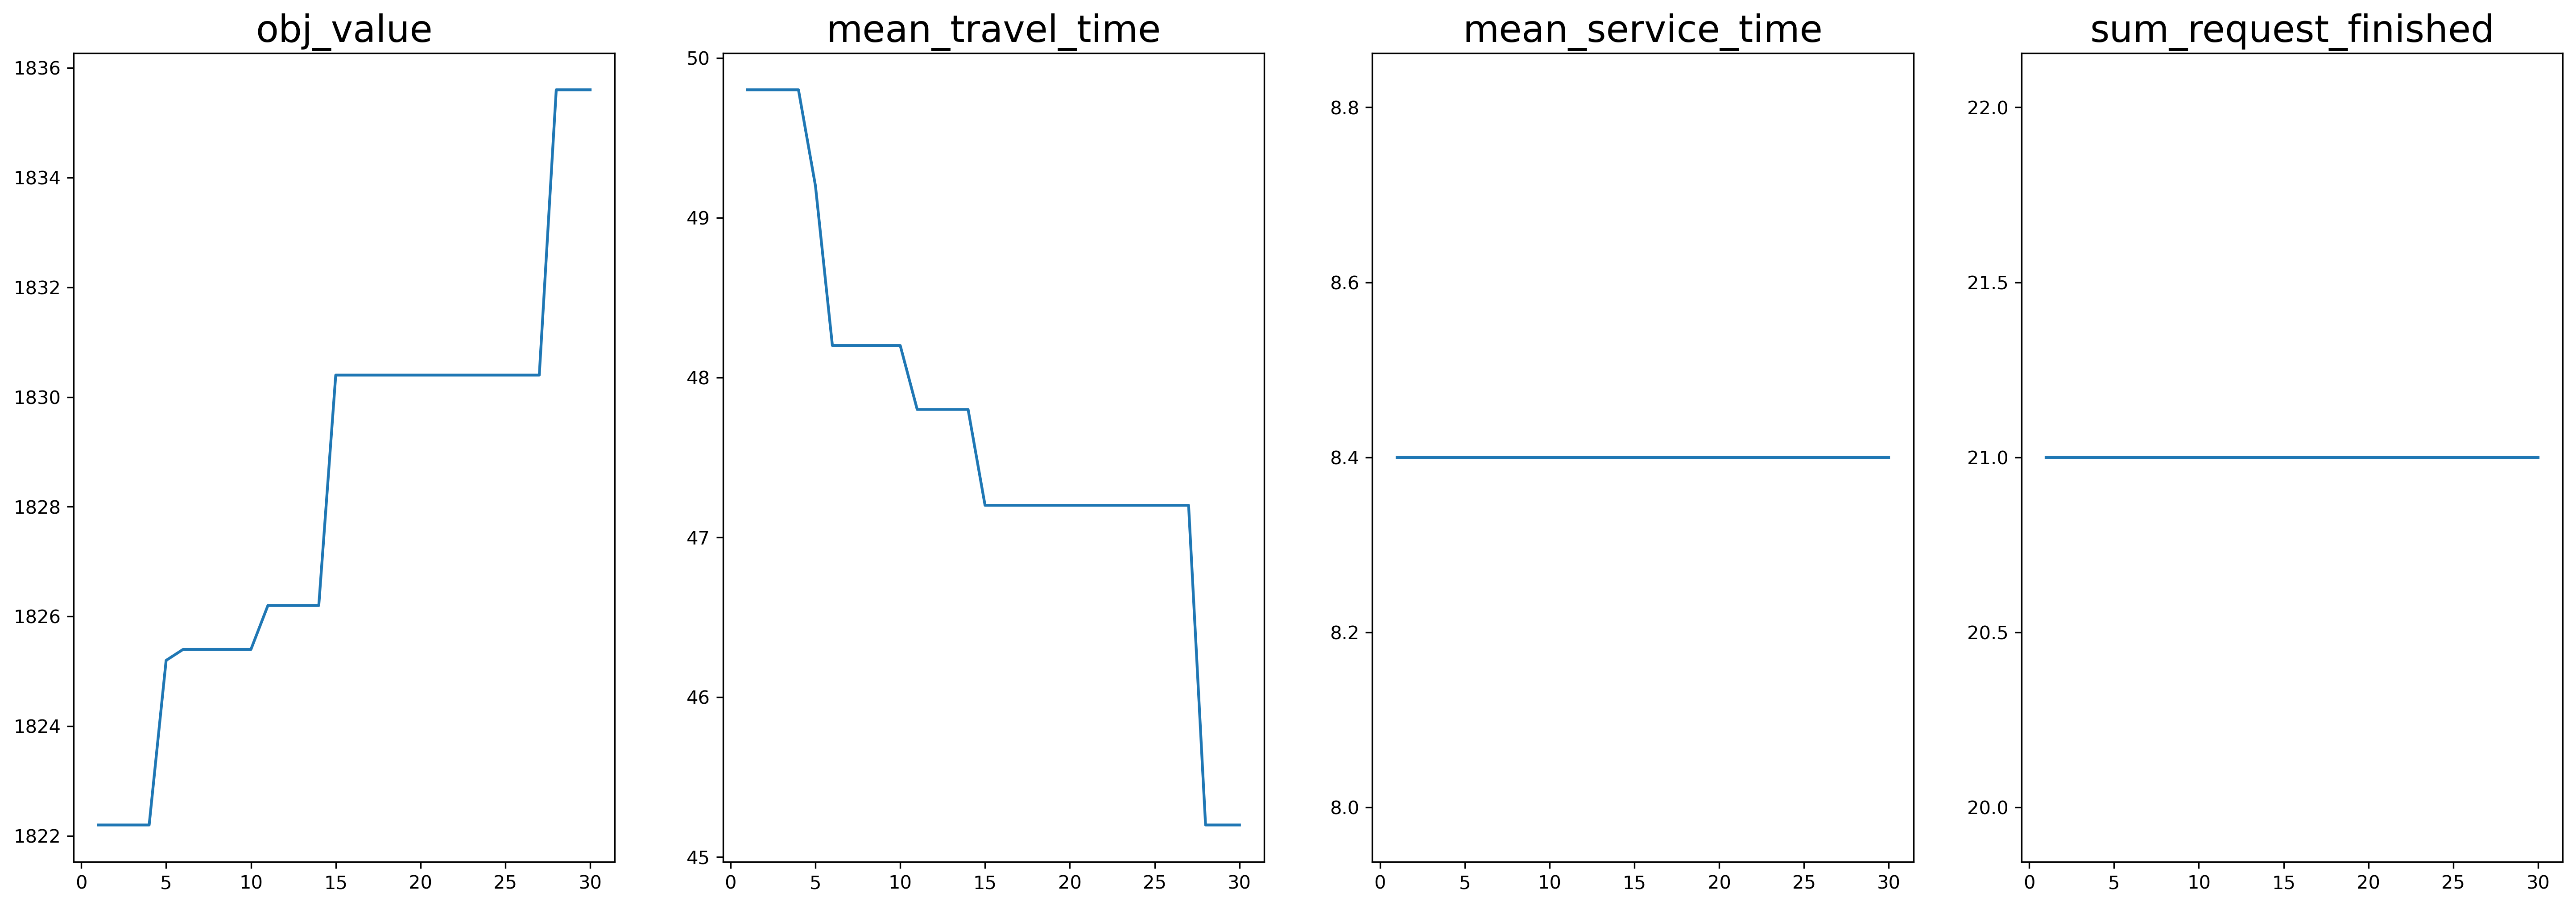

{'route': [['G9', 'E7', 'C8', 'C9', 'A6'], ['H4'], [], ['C3', 'A3'], ['C4', 'A4', 'B5'], []], 'total_time': [122.0, 28.0, 0, 47.0, 71.0, 0], 'travel_time': [108.0, 24.0, 0, 33.0, 61.0, 0], 'service_time': [14, 4, 0, 14, 10, 0], 'n_requests_finished': [7, 2, 0, 7, 5, 0], 'obj_value': 1835.6, 'comp_time': 34.62476181983948}


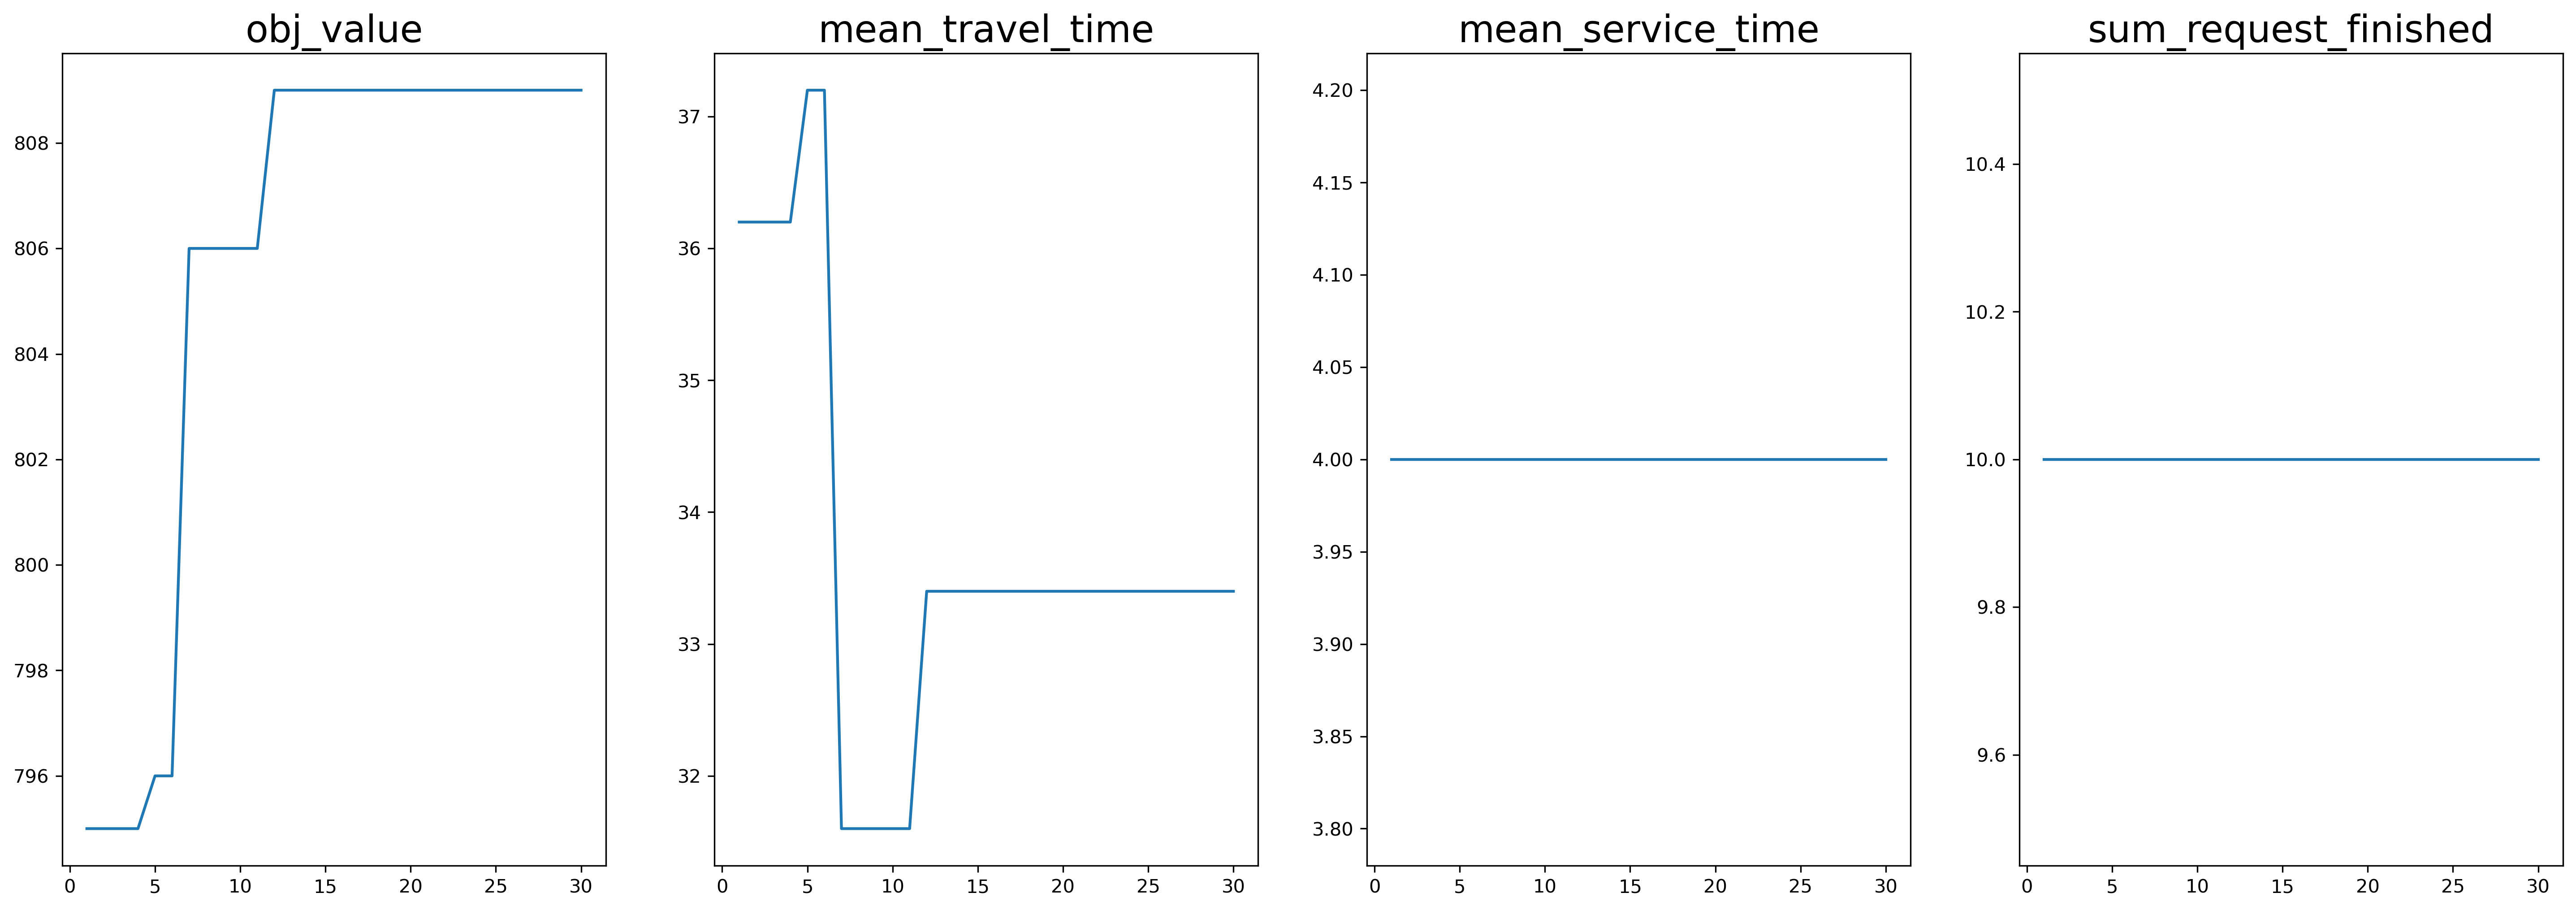

{'route': [['A5', 'C11', 'A6', 'D6', 'H6'], [], ['G10', 'H10', 'E9'], [], ['G7'], []], 'total_time': [103.0, 0, 53.0, 0, 31.0, 0], 'travel_time': [93.0, 0, 47.0, 0, 27.0, 0], 'service_time': [10, 0, 6, 0, 4, 0], 'n_requests_finished': [5, 0, 3, 0, 2, 0], 'obj_value': 809.0, 'comp_time': 30.58689308166504}


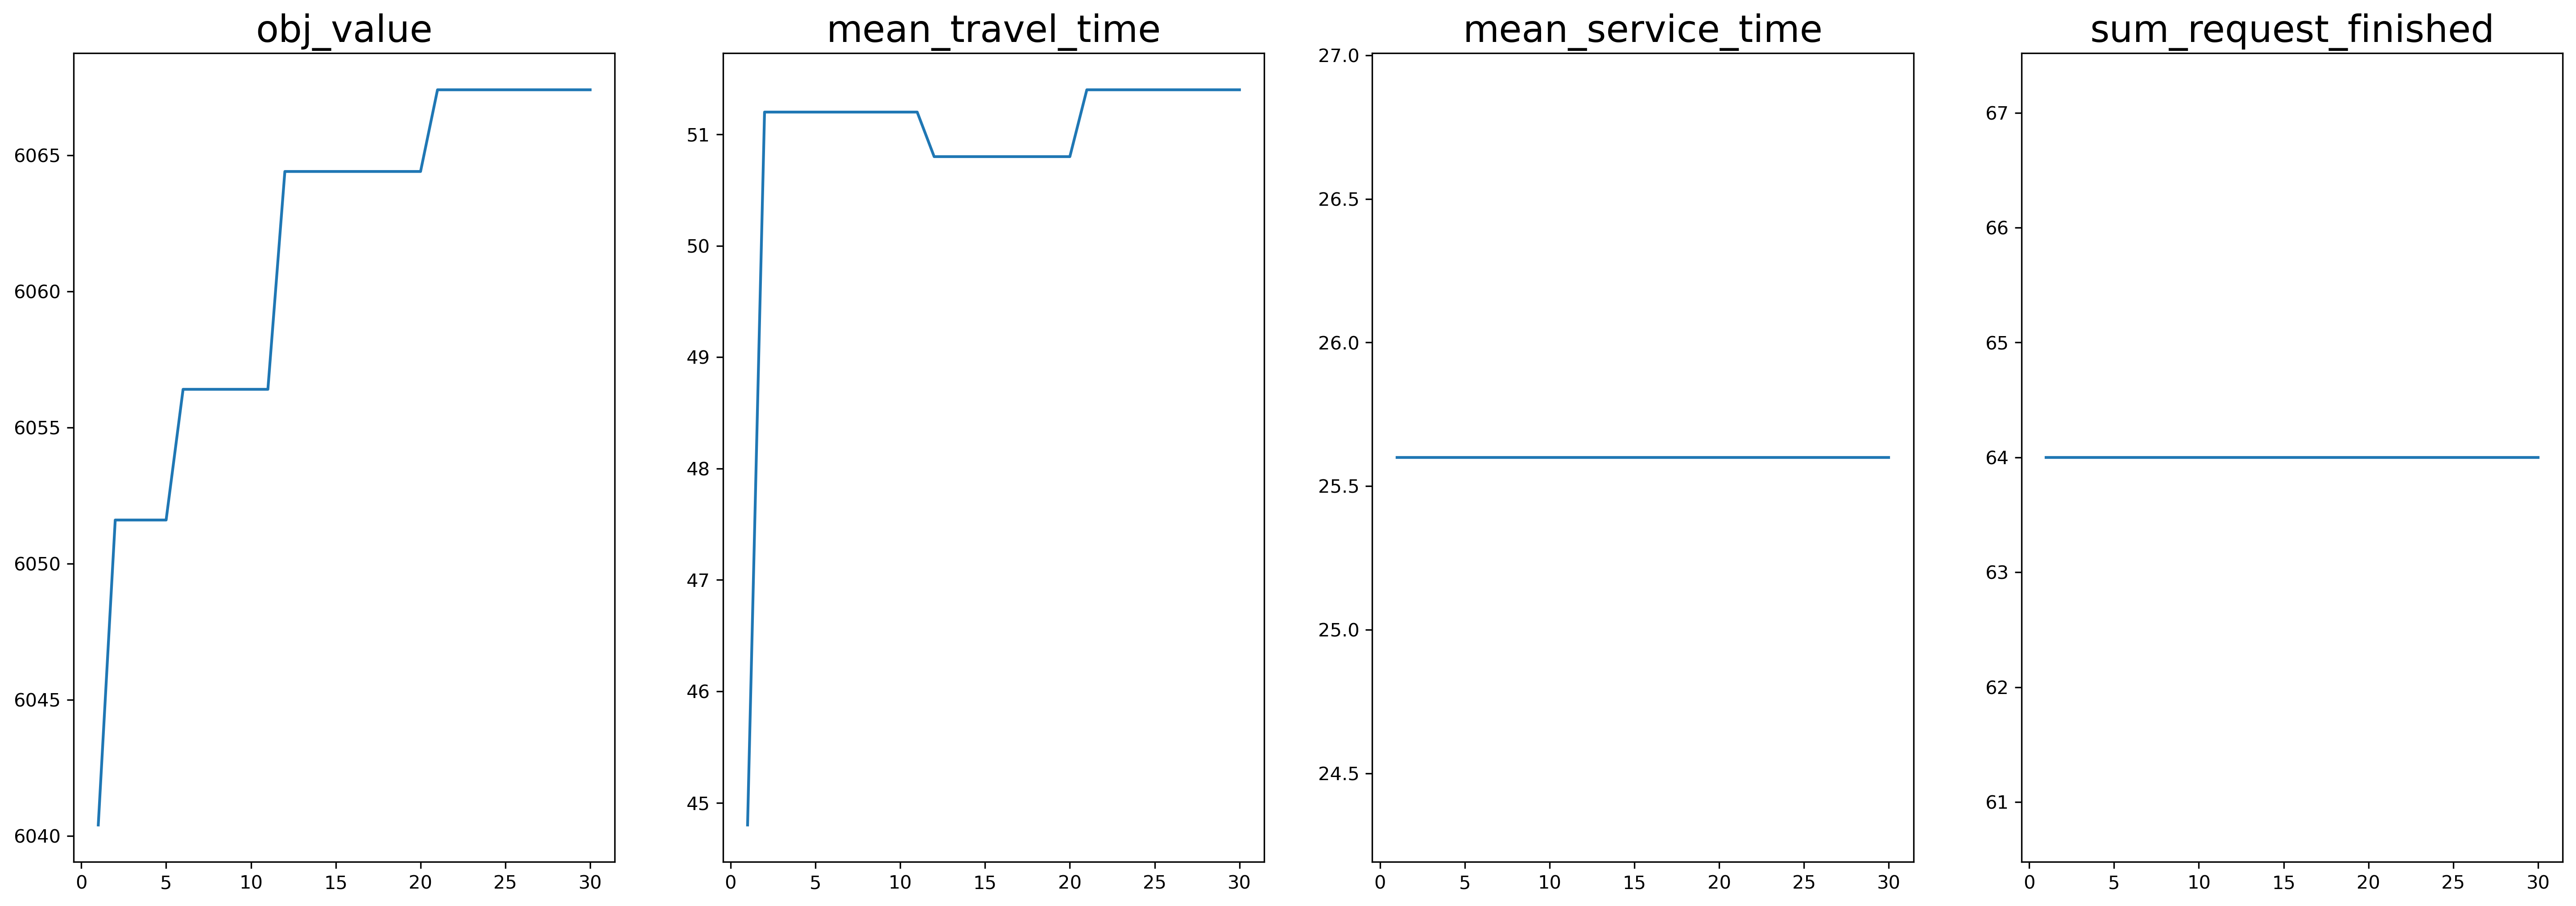

{'route': [['G7', 'C7', 'C8', 'A8', 'C9', 'A10'], ['F8', 'G8', 'H8', 'E8', 'H6'], ['G6', 'C6', 'D6'], ['A1', 'B6', 'A6', 'E6'], ['H4'], []], 'total_time': [135.0, 76.0, 66.0, 82.0, 26.0, 0], 'travel_time': [89.0, 50.0, 42.0, 52.0, 24.0, 0], 'service_time': [46, 26, 24, 30, 2, 0], 'n_requests_finished': [23, 13, 12, 15, 1, 0], 'obj_value': 6067.4, 'comp_time': 50.43156719207764}


[{'route': [['B5', 'B10', 'C9', 'C7', 'E7', 'G7'],
   ['G10', 'H10', 'E8', 'E6', 'G6'],
   ['C6', 'A6'],
   ['A3', 'C3', 'B2'],
   [],
   []],
  'total_time': [123.0, 92.0, 48.0, 75.0, 0, 0],
  'travel_time': [103.0, 68.0, 36.0, 67.0, 0, 0],
  'service_time': [20, 24, 12, 8, 0, 0],
  'n_requests_finished': [10, 12, 6, 4, 0, 0],
  'obj_value': 2870.8,
  'comp_time': 44.36354470252991},
 {'route': [['A8', 'C8', 'A10', 'B10', 'C11', 'C7', 'A7', 'E7'],
   ['A4', 'C4', 'E4', 'H4', 'G4', 'E11'],
   ['H10', 'G10', 'E8', 'H8', 'G7', 'H7'],
   ['C6', 'D6', 'A6', 'B6', 'E6', 'H6', 'G6', 'E2', 'G2'],
   ['H3'],
   []],
  'total_time': [127.0, 130.0, 123.0, 113.0, 27.0, 0],
  'travel_time': [93.0, 88.0, 71.0, 83.0, 23.0, 0],
  'service_time': [34, 42, 52, 30, 4, 0],
  'n_requests_finished': [17, 21, 26, 15, 2, 0],
  'obj_value': 7649.6,
  'comp_time': 81.61424493789673},
 {'route': [['G7', 'E7', 'C7', 'A7', 'A11', 'B10', 'B9', 'C9'],
   ['E9', 'F10'],
   ['E3', 'H3', 'A3'],
   ['B2'],
   ['E4', 'A

In [7]:
GA(df,node,n_vehicle,start,n_population,p_mutate,n_iteration)